<a href="https://colab.research.google.com/github/patherlkd/ActiveMatterIn2Science/blob/main/VicsekModelCode-binder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vicsek Model Simulation: Exploring active aligning particles

## Written by Dr Luke K. Davis
### University College London Department of Mathematics
E: luke.davis@ucl.ac.uk

Based on code initially written by Francesco Turci

### Running the interactive simulation

1. Click "Runtime" then "Run all", which will run the whole notebook ready for you to start playing with.

2. Scroll down to the last cell and run it as per instructions. Click the ``Run Interact`` button to run a simulation.

Note: The simulations are not instantaneous, your are running full-fledged active matter simulation(!), though should not take too long (~1-3 minutes for moderate parameters)

3. Play with the sliders:
  
  
![Alt text](./sliders.png?raw=true "What the simulation looks like")

### Guiding questions/pointers to help you explore the active matter simulations

The main thing is for you to explore the system, code, and setup to get a feel of running computational simulations. So, follow you curiosity. If you want some nudges of what to look at then see below.

These questions/pointers typically get more difficult as you progress through them.

+ For each slider, investigate what they do [check at least three values] and how they affect the runtime of the simulation.
+ How can I get all the arrows aligned? There might be more than one way to do this, so write them down!
+ How can I get all the arrows to be disordered?
+ Is the transition between disordered and all-aligned gradual or sharp?
+ How does the number of particles affect what you see?
+ How does the initial condition of the particles change things?
+ What could be the problem of only looking at short simulation "Iterations"?
+ From the code cells, extract and explain the lines of code implementing periodic boundary conditions? Research why are they used?
+ From the code cells, extract and explain the lines of code implementing the equations of motion. Write down the equations and show that discretising them allows for their numerical solution.
+ How could you edit the code to implement (isotropic) repulsion between the particles?
+ Edit the code so that the self-propulsion can be changed using a slider.
+ Edit the code to compute (and then plot) the average alignment of particles as a function of time.
+ Edit the code to include obstacles for the particles.
+ Edit the code to incorporate non-reciprocal interactions.

## Preamble (Import packages and setup plotting things)

In [ ]:
%%capture
#!conda install -y -q ffmpeg
#%matplotlib widget
import sys
import numpy as np
import scipy as sp
from scipy import sparse
from scipy.spatial import cKDTree
import matplotlib as mplt
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation # animation (video)
import matplotlib.gridspec as gridspec # fancy subplots
from IPython.display import HTML # shows animation in jupyter
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual




In [ ]:
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
print(sys.version)
print("Numpy version: "+np.__version__)
print("Scipy version: "+sp.__version__)
print("Matplotlib version: "+mplt.__version__)
print("ipywidgets version: "+widgets.__version__)

3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
Numpy version: 1.23.5
Scipy version: 1.10.1
Matplotlib version: 3.7.1
ipywidgets version: 7.7.1


In [ ]:
ff = 2
space         = ff*0.07
nb_lines      = ff*1
fig_width_pt  = 246.
inches_per_pt = 1./72.
golden_mean   = .66
fig_width     = fig_width_pt*inches_per_pt
fig_height    = (fig_width*golden_mean)+space
fig_size      = [ff*fig_width, ff*fig_height]
params = {'font.family': "Serif",
        'legend.fontsize': ff*7,
          'axes.linewidth': ff*5e-1,
          'axes.labelsize': ff*10,
          #'text.fontsize': ff*7,
          'xtick.labelsize': ff*7,
          'ytick.labelsize': ff*7,
          'text.usetex': False,
          'text.latex.preamble':"\\usepackage{color}",
          'figure.figsize': fig_size}

plt.rcParams.update(params)

## Define the Vicsek simulation class

In [ ]:

class VicsekSimulation:


    def __init__(self,rho,eta):
        # Some constants
        self.cnt =1 # Simulation label
        self.L = 32.0 # Box length
        self.factor = 0.5 # factor of propulsion
        self.deltat = 1.0 # Delta t for integration dynamics



    def run(self,rho,eta,r0,pi_frac=1.0,L_frac=1.0,move=True,iterations=250):

        # Some code to label the video screen and organize plot
        print("Simulation number: "+str(self.cnt))
        print("Click on the video to pause or resume it. The different colors represent orientations.")
        plt.close('all')
        self.fig, self.ax= plt.subplots()
        self.ax.set_title('Vicsek Model Simulation')
        self.ax.set_xlim(0.0,32)
        self.ax.set_ylim(0.0,32)
        self.ax.set(xlabel='x',ylabel='y')
        self.ax.tick_params(which='both',labelsize=25,direction='in',left=True,right=True,top=True,bottom=True)
        self.time_text = self.ax.text(0.02, 1.0, '', transform=self.ax.transAxes,fontsize='x-large')

        # Assign function arguments to class variables
        self.iterations= iterations # number of total iterations of integrating dynamics
        self.rho = rho # density
        self.eta=eta # orientational noise strength
        self.r0 = r0 # interaction range
        if move:
            self.factor = 0.5 # factor of propulsion
        else:
            self.factor = 0.0

        self.N = int(self.rho*self.L**2) # Total number of particles
        self.v0 = self.factor/self.deltat # propulsion

        # Initialize positions and orientations of the particles
        self.pos = np.random.uniform(0,L_frac*self.L,size=(self.N,2))
        self.orient = np.random.uniform(-np.pi, pi_frac*np.pi,size=self.N)

        # Initiatiate the matplotlib quiver object (that nicely displays arrows)
        self.qv = self.ax.quiver(self.pos[:,0], self.pos[:,1], np.cos(self.orient[0]), np.sin(self.orient), self.orient, clim=[-np.pi, np.pi])
        self.fig.tight_layout(pad=1.0)
        # Animate the plot
        self.anim = FuncAnimation(self.fig,self.update,frames=self.iterations,interval=100, blit=True,repeat=False)
        #self.paused = False

        # Some video/notebook specific things
        #self.fig.canvas.mpl_connect('button_press_event', self.toggle_pause)
        #HTML(self.anim.to_jshtml())
        #print(">> Video about to show >>")
        display(HTML(self.anim.to_html5_video()))
        # Update the simulation label (useful for keeping track of many simulations run in the window)
        self.cnt+= 1

    def toggle_pause(self, *args, **kwargs):
        ## Function to implement pausing of video upon button click
        if self.paused:
            self.anim.resume()
        else:
            self.anim.pause()
        self.paused = not self.paused

    def update(self,i):

        # Show simulation progress
        #self.time_text.set_text("Progress: "+str(round(i/self.iterations,2)))
        if i%50==0:
          print(">>LOADING",end=">>")
          if i%200==0:
            print("")

        # Nearest neighbour lookup
        tree = cKDTree(self.pos,boxsize=[self.L,self.L])
        dist = tree.sparse_distance_matrix(tree, max_distance=self.r0,output_type='coo_matrix')

        #important 3 lines: we evaluate a quantity for every column j
        data = np.exp(self.orient[dist.col]*1j)
        # construct  a new sparse marix with entries in the same places ij of the dist matrix
        neigh = sparse.coo_matrix((data,(dist.row,dist.col)), shape=dist.get_shape())
        # and sum along the columns (sum over j)
        S = np.squeeze(np.asarray(neigh.tocsr().sum(axis=1)))

        # Re-assign the orientation vector (based on alignment [first term] and noise [second term])
        self.orient = np.angle(S)+self.eta*np.random.uniform(-np.pi, np.pi, size=self.N)

        # Update the positions
        cos, sin= np.cos(self.orient), np.sin(self.orient)
        self.pos[:,0] += cos*self.v0*self.deltat
        self.pos[:,1] += sin*self.v0*self.deltat

        # Apply periodic boundary conditions
        self.pos[self.pos>self.L] -= self.L
        self.pos[self.pos<0] += self.L

        # Update the plot
        self.qv.set_offsets(self.pos)
        self.qv.set_UVC(cos, sin,self.orient)

        return self.qv,







## Run the interactive simulation

You should run the cell below to initiate the sliders, that will change specific parameters to run a simulation of the Vicsek model.

Please click the

``Run Interact``

button below each time you want to visualize the simulation. You should -- ideally -- wait for the simulation video to finish before you run the next one. You can pause, maximize, and save (right-click (i think)) the video.

**PLEASE _WAIT_ FOR VIDEO TO SHOW. The >>LOADING>> messages means it is loading and not yet ready.**

interactive(children=(FloatSlider(value=3.0, description='Density: ', layout=Layout(width='25%'), max=3.0, min…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

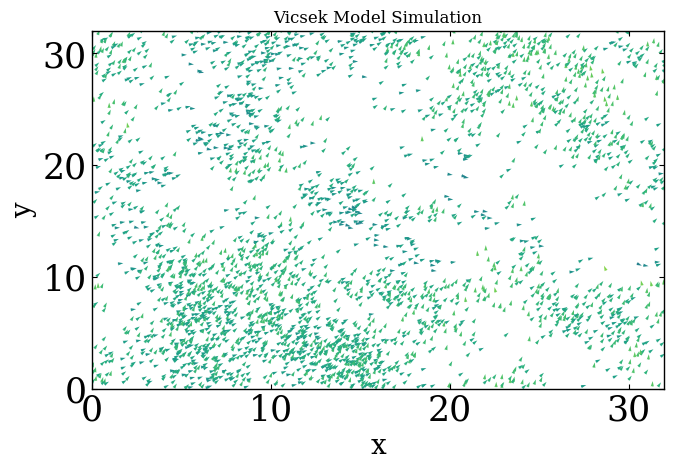

In [ ]:
# Make an instance of the simulation
v=VicsekSimulation(3.0,0.15)

# Make the simulation 'interactive'
style = {'description_width': 'initial'}
interact_manual(v.run,rho=widgets.FloatSlider(description='Density: ',value=3.0,min=0.5,max=3,step=0.1,style=style,layout=widgets.Layout(width='25%')),eta=widgets.FloatSlider(description='Noise: ', value=0.15,min=0.0,max=1,step=0.1,style=style),
               r0=widgets.FloatSlider(description='Interaction range: ', value=1.0,min=0.0,max=3.0,step=0.5,style=style),
                pi_frac=widgets.FloatSlider(description='Initial degree of alignment [e.g. 1.0 = random, -0.1 = more aligned]: ', value=1.0,min=-0.1,max=1.0,step=0.1,style=style,layout=widgets.Layout(width='35%')),
                L_frac=widgets.FloatSlider(description='Initial coverage of box [e.g. 1.0 = cover all box, 0.5 = cover (0.5^2 = 0.25) of box]: ', value=1.0,min=0.1,max=1.0,step=0.1,style=style,layout=widgets.Layout(width='40%')),
                move=widgets.Checkbox(description='Arrows move',value=True),
               iterations=widgets.IntSlider(description='Iterations: ', value=250,min=50,max=500,style=style,layout=widgets.Layout(width='30%')))
